# 3. Find and Classify Cells

In [2]:
from predict import predict_path, post_processing, make_pred_dataframe
from dataset import TNBC2, TNBC1
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import config
import pandas as pd
c = config.Config()

(3372, 3372, 3) (3372, 3372) (3372, 3372) (3372, 3372)


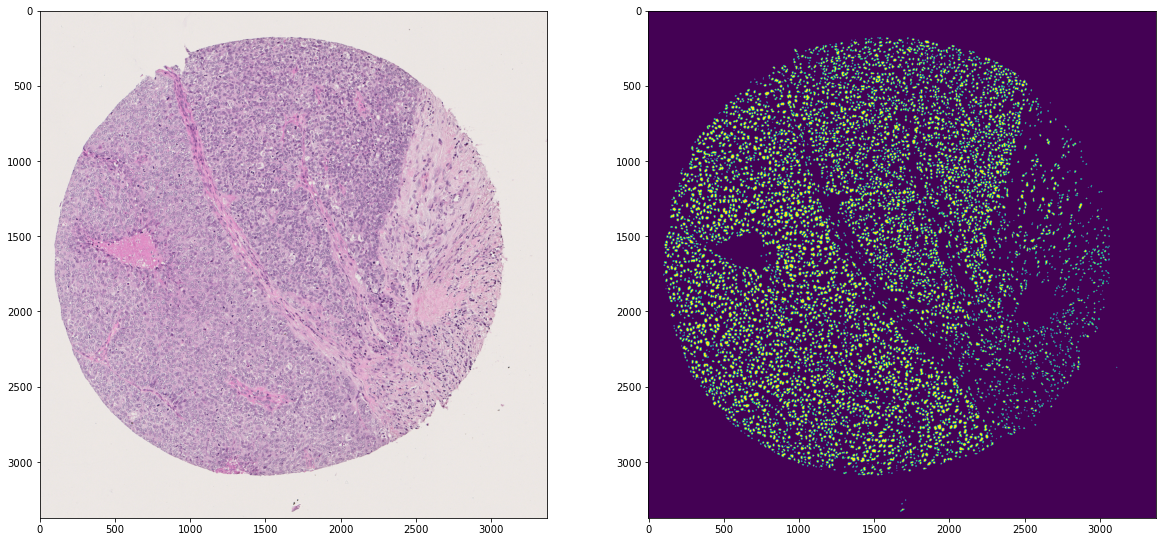

In [3]:
tnbc = TNBC1()
model_name = 'quip2'
stride = c.WIDTH//2

tumor_cells = []
immune_cells = []
sizes = []

n = 10
size_limit = 5
d = []
cutoff = 0.2
scale = 1.0
for imid in tnbc.ids[3:4]:
    path = tnbc.file_name(imid)
    img = tnbc.load_image(imid)
    pred = predict_path(path, model_name, stride, scale)
    mask = post_processing(pred, cutoff, size_limit)

    df_pred = make_pred_dataframe(imid, mask, img)
    pred_class = np.zeros_like(mask).astype(np.uint8)
    for _, row in df_pred[df_pred["image_id"] == imid].iterrows():
        obj = row["obj"]
        s = 5
        obj = (slice(obj[0].start-s, obj[0].stop+s, None),
              slice(obj[1].start-s, obj[1].stop+s, None))
        sizes.append(row["mask"].sum())
        if row["class_name"] == "immune cells":
            immune_cells.append(img[obj])
        elif row["class_name"] == "tumor":
            tumor_cells.append(img[obj])
        else:
            print(row["class_name"])
        pred_class[row["obj"]] = (1 + row["class"]) * row["mask"]



    print(img.shape, pred.shape, mask.shape, pred_class.shape)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(mask, alpha=1.0)
    d.append(
    {
        "cutoff" : cutoff,
        "n_immune" : df_pred["class_name"].value_counts()["immune cells"],
        "n_tumor" : df_pred["class_name"].value_counts()["tumor"],
    })
df = pd.DataFrame(d)

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


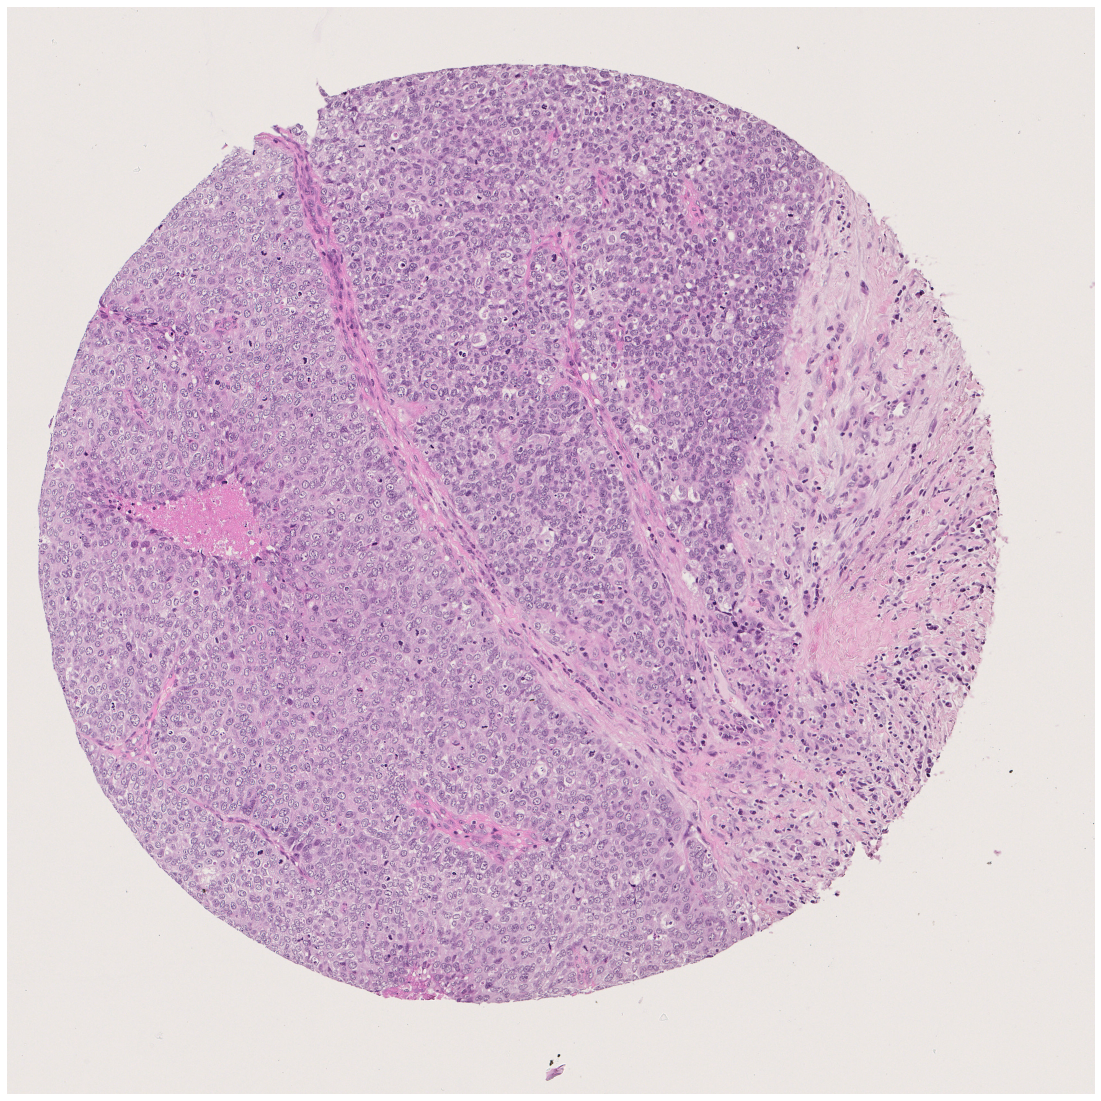

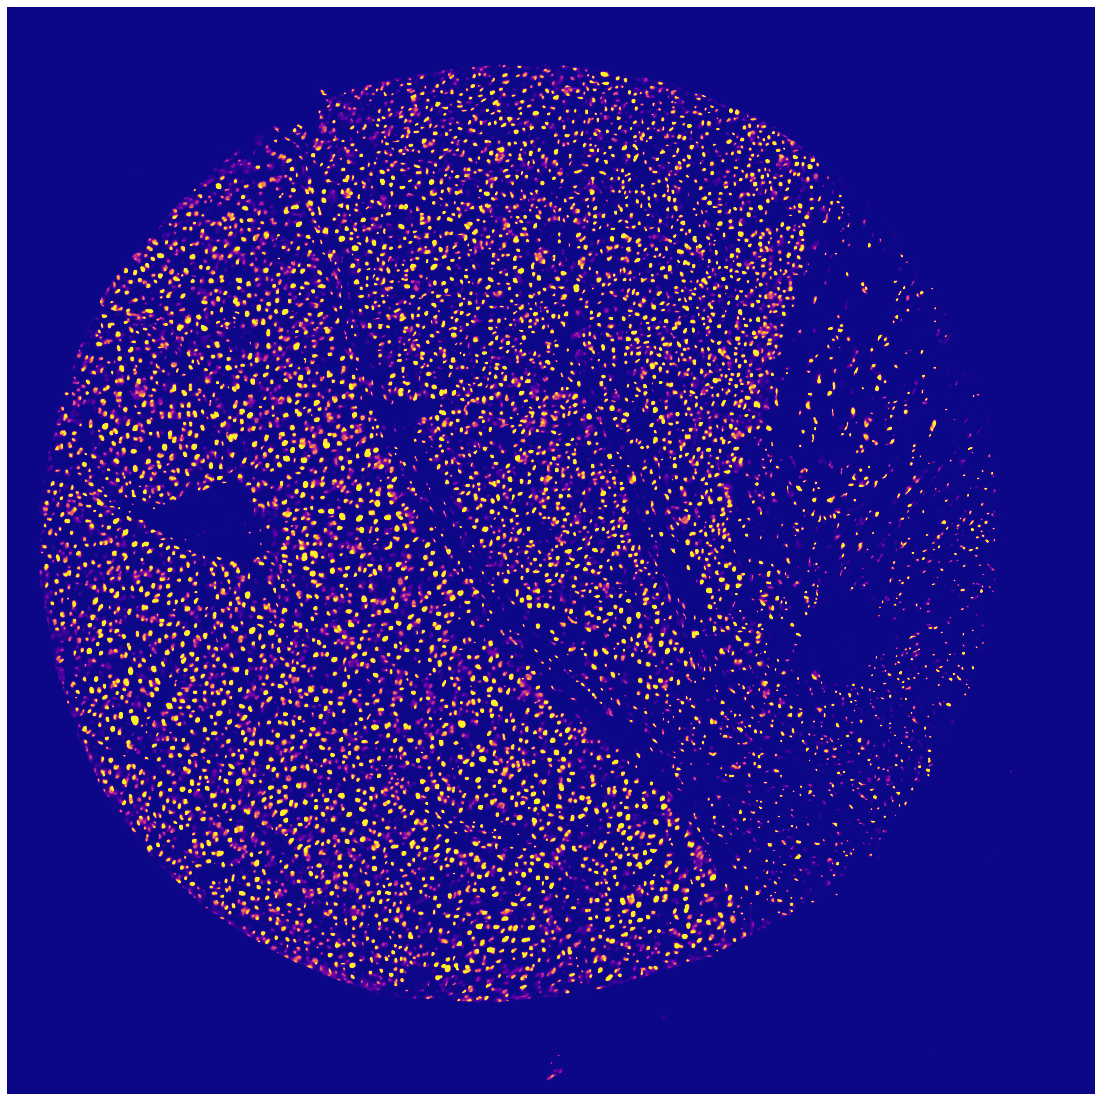

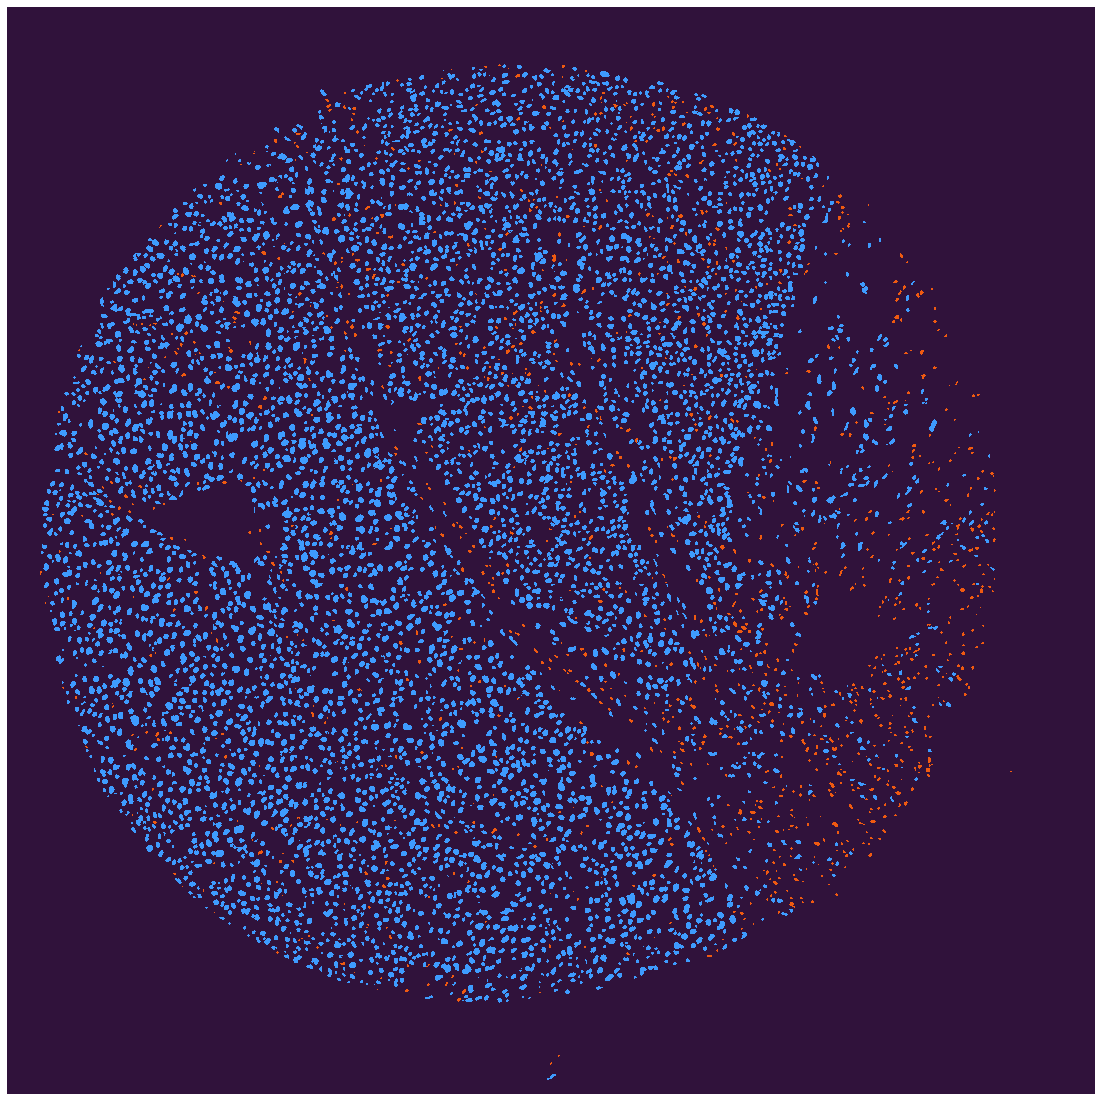

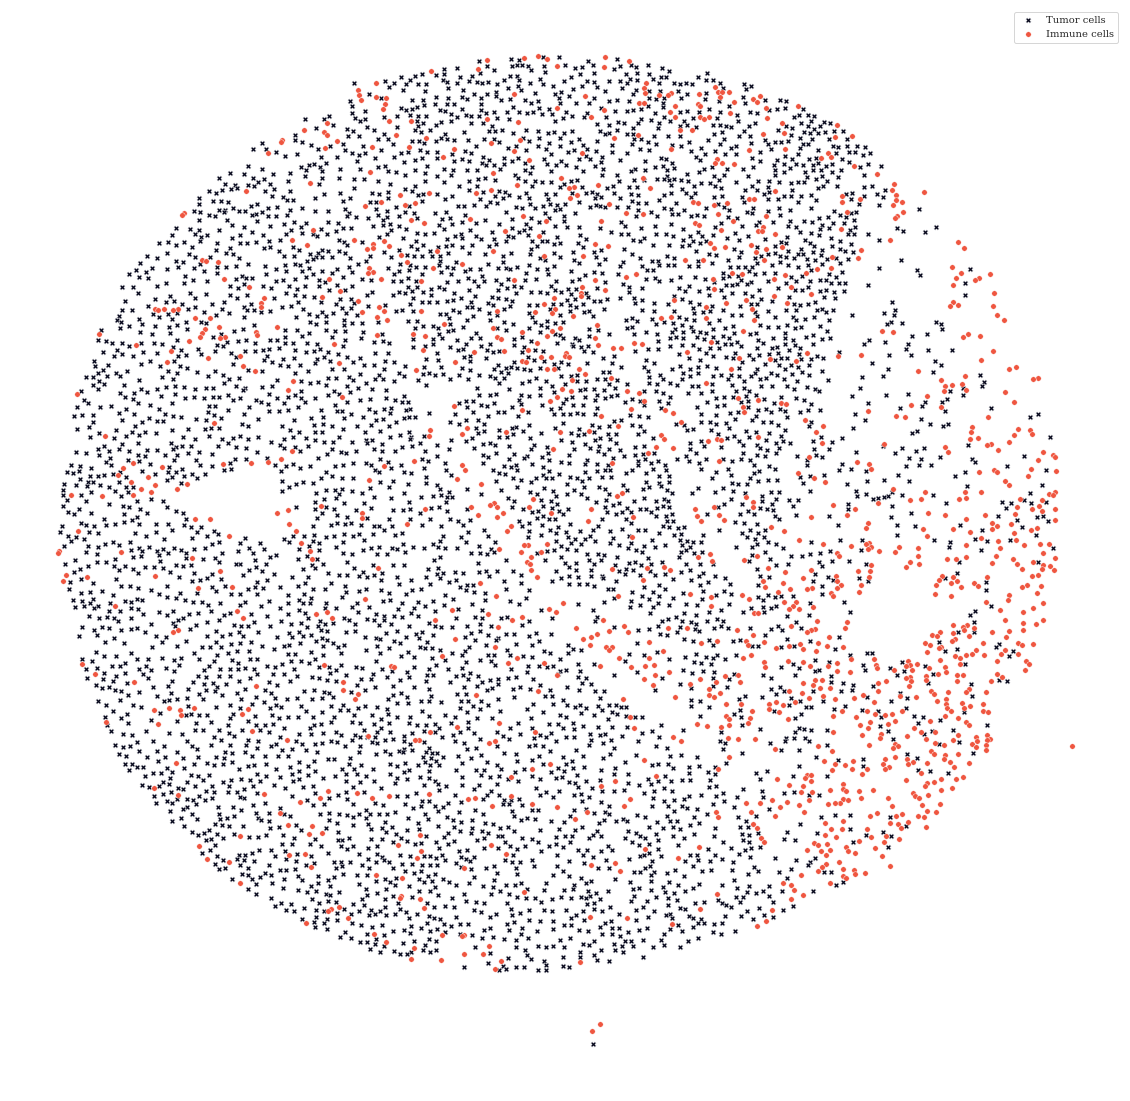

In [117]:
import seaborn as sns
import matplotlib
from predict import make_patient_dataframe
sns.set_style("whitegrid", {'axes.grid' : False})
matplotlib.rcParams['font.family'] = "serif"
width = 20
size = (width, width)

plt.figure(figsize=size)
plt.imshow(img)
plt.axis('off')
plt.savefig("../docs/tma_img.svg", bbox_inches='tight')

plt.figure(figsize=size)
plt.imshow(pred, cmap='plasma', vmax=0.4)
plt.axis('off')
plt.savefig("../docs/tma_pred.svg", bbox_inches='tight')

plt.figure(figsize=size)
plt.imshow(pred_class**2, cmap='turbo', interpolation='nearest', vmax=5, vmin=0.0)
plt.axis('off')
plt.savefig("../docs/tma_pred_class.svg", bbox_inches='tight')

plt.figure(figsize=size)
ax = plt.gca()
ax.invert_yaxis()
df_cells = make_pred_dataframe(imid, mask, img)
df_pat = make_patient_dataframe(df_cells)

s = 15*2
tumor_loc = df_pat["tumor_loc"].iloc[0]
immune_loc = df_pat["immune_loc"].iloc[0]
args = lambda locs: list(zip(*locs))[::-1]
sns.scatterplot(*args(tumor_loc), label="Tumor cells", s=s, marker='X', c=['#04051A'])
sns.scatterplot(*args(immune_loc), label="Immune cells", s=s, marker='o', c=['#EF5640'])
plt.axis('off')
plt.savefig("../docs/tma_plot.svg", bbox_inches='tight')


(3372, 3372, 3) (3372, 3372) (3372, 3372) (3372, 3372)


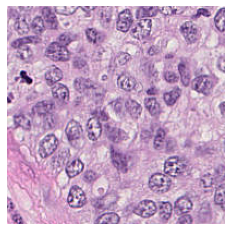

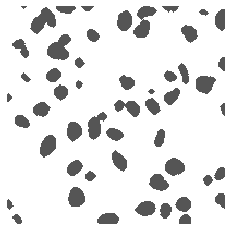

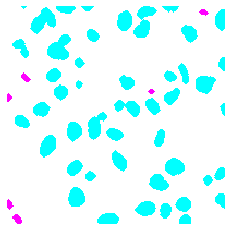

In [118]:
x = 1300
y = x
size = 200
save_options = {
    "bbox_inches" : "tight",
    "pad_inches" : 0,
}
print(img.shape, pred.shape, mask.shape, pred_class.shape)
m = (slice(x, x + size, None), slice(y, y + size, None))
cmap = 'twilight'
plt.figure()
plt.axis('off')
plt.imshow(img[m])
plt.savefig('../docs/small_tissue.png', **save_options)

plt.figure(frameon=False)
plt.imshow(mask[m], cmap='binary', vmin=0, vmax=1.5, interpolation='nearest')
plt.axis('off')
plt.savefig('../docs/small_binary_mask.png', bbox_inches='tight')

plt.figure()
plt.imshow(pred_class[m], alpha = np.array(pred_class[m]), cmap='cool', vmin=1, interpolation='nearest')
plt.axis('off')
plt.savefig('../docs/small_class_mask.png', bbox_inches='tight')

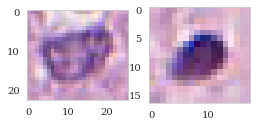

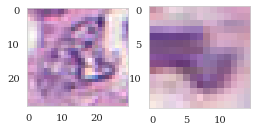

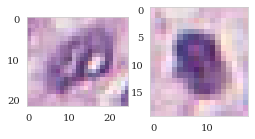

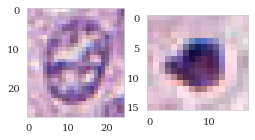

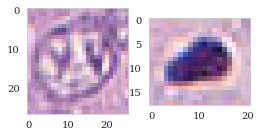

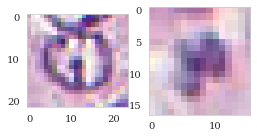

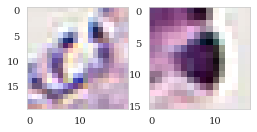

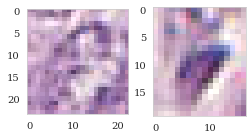

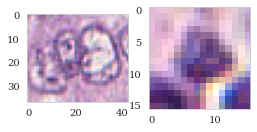

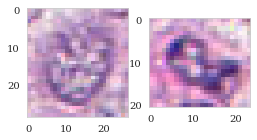

In [119]:
k = 10
for t, i in zip(random.choices(tumor_cells, k=k),
                random.choices(immune_cells, k=k)):
    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(t)
    plt.subplot(122)
    plt.imshow(i)